In [160]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost
import inspect
from collections import defaultdict
from tabpfn import TabPFNClassifier
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [161]:
train = pd.read_csv('./icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('./icr-identify-age-related-conditions/test.csv')
sample = pd.read_csv('./icr-identify-age-related-conditions/sample_submission.csv')
greeks = pd.read_csv('./icr-identify-age-related-conditions/greeks.csv')

first_category = train.EJ.unique()[0]
train.EJ = train.EJ.eq(first_category).astype('int')
test.EJ = test.EJ.eq(first_category).astype('int')

In [162]:
int_denominators = {
    'AB': 0.004273,
    'AF': 0.00242,
    'AH': 0.008709,
    'AM': 0.003097,
    'AR': 0.005244,
    'AX': 0.008859,
    'AY': 0.000609,
    'AZ': 0.006302,
    'BC': 0.007028,
    'BD ': 0.00799,
    'BN': 0.3531,
    'BP': 0.004239,
    'BQ': 0.002605,
    'BR': 0.006049,
    'BZ': 0.004267,
    'CB': 0.009191,
    'CC': 6.12e-06,
    'CD ': 0.007928,
    'CF': 0.003041,
    'CH': 0.000398,
    'CL': 0.006365,
    'CR': 7.5e-05,
    'CS': 0.003487,
    'CU': 0.005517,
    'CW ': 9.2e-05,
    'DA': 0.00388,
    'DE': 0.004435,
    'DF': 0.000351,
    'DH': 0.002733,
    'DI': 0.003765,
    'DL': 0.00212,
    'DN': 0.003412,
    'DU': 0.0013794,
    'DV': 0.00259,
    'DY': 0.004492,
    'EB': 0.007068,
    'EE': 0.004031,
    'EG': 0.006025,
    'EH': 0.006084,
    'EL': 0.000429,
    'EP': 0.009269,
    'EU': 0.005064,
    'FC': 0.005712,
    'FD ': 0.005937,
    'FE': 0.007486,
    'FI': 0.005513,
    'FR': 0.00058,
    'FS': 0.006773,
    'GB': 0.009302,
    'GE': 0.004417,
    'GF': 0.004374,
    'GH': 0.003721,
    'GI': 0.002572
}
for k, v in int_denominators.items():
    train[k] = np.round(train[k] / v, 1)
    test[k] = np.round(test[k] / v, 1)

# ff = ['Id', 'AH', 'BN', 'BQ', 'CB', 'CC', 'CR', 'CU', 'DA', 'DE', 'DN', 'EE', 'EP', 'FI', 'GF', 'Class']
# gg = ['Id', 'AH', 'BN', 'BQ', 'CB', 'CC', 'CR', 'CU', 'DA', 'DE', 'DN', 'EE', 'EP', 'FI', 'GF']
# train = train[ff]
# test = test[gg]

In [163]:
Imp = SimpleImputer(missing_values=np.nan, strategy='median')

columns_to_select = [col for col in train.columns if col not in ['Class', 'Id']]

train_data = train[columns_to_select].copy()
test_data = test[columns_to_select].copy()

# 填充缺失值
train_data = pd.DataFrame(Imp.fit_transform(train_data), columns=columns_to_select)
test_data = pd.DataFrame(Imp.transform(test_data), columns=columns_to_select)

# 重新组合数据和原始列
train_filled = pd.concat([train['Id'], train_data, train['Class']], axis=1)
test_filled = pd.concat([test['Id'], test_data], axis=1)

train = train_filled.copy()
test = test_filled.copy()
# print(train.shape, test.shape)

In [164]:
from sklearn.cluster import KMeans

k = 7
BNpd = train['BN']

BNpd = pd.concat([train['BN'], test['BN']], axis=0, ignore_index=True)
data = BNpd.values.reshape(-1, 1)
kmodel = KMeans(n_clusters=k)           # k为聚成几类
kmodel.fit(data)  # 训练模型
c = pd.DataFrame(kmodel.cluster_centers_, columns=['cc']) # 求聚类中心
c0 = pd.DataFrame({'cc': [0.0]})
c = pd.concat([c0, c], axis=0, ignore_index=True)
c = c.sort_values(by='cc').reset_index(drop=True)

# 求聚类中心之间的平均值作为分割点
for i in range(c.shape[0] - 1):
    c.iloc[i]['cc'] = (c.iloc[i]['cc'] + c.iloc[i+1]['cc']) / 2
c = c.drop(c.index[-1])

c0 = pd.DataFrame({'cc': [0.0]})
cn = pd.DataFrame({'cc': [max(train['BN'].max(), test['BN'].max()) * 5]})
c = pd.concat([c0, c, cn], axis=0, ignore_index=True)
c = c['cc'].round().astype(int)
c = c.unique()
range_num = c.shape[0] - 1
c = c.tolist()

# 保留旧BN，添加BN_binning
train_BN = train['BN'].values
train_binning = pd.cut(train_BN, c, labels=range(range_num), include_lowest=True).astype(int)
train['BN_binning'] = train_binning
print(train['BN_binning'].value_counts())

test_BN = test['BN'].values
test_binning = pd.cut(test_BN, c, labels=range(range_num), include_lowest=True).astype(int)
test['BN_binning'] = test_binning

BN_binning
3    207
4    142
5     95
2     89
6     54
1     30
Name: count, dtype: int64


In [165]:
y_meta = greeks['Alpha']
X = train.drop(columns=['Id', 'Class'])
y = train['Class']

In [166]:
from sklearn.metrics import make_scorer
from sklearn.metrics import log_loss

def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15, labels=[0, 1])

def calc_loss(y_pred, y):
    probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:, 1:], 1, keepdims=True)), axis=1)
    p0 = probabilities[:, :1]       # 计算class=0的概率
    p1 = 1 - p0
    
    y = y.values.astype(int)
    loss = balanced_log_loss(y, p1)

    return loss

def meta_to_bll(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    y_true = np.array([0 if x == 0 else 1 for x in y])
    probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:, 1:], 1, keepdims=True)), axis=1)
    p0 = probabilities[:, :1]       # 计算class=0的概率
    p1 = 1 - p0

    loss = balanced_log_loss(y_true, p1)
    return -loss # Note: Scikit-learn interprets higher return values as better, so you should return negative loss if you're minimizing loss.


In [167]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
import shap

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=10)
fit = model.fit(X_train, y_train)
# yhat = model.predict(X_test)
# results = balanced_log_loss(y_test, yhat)
# print(results)

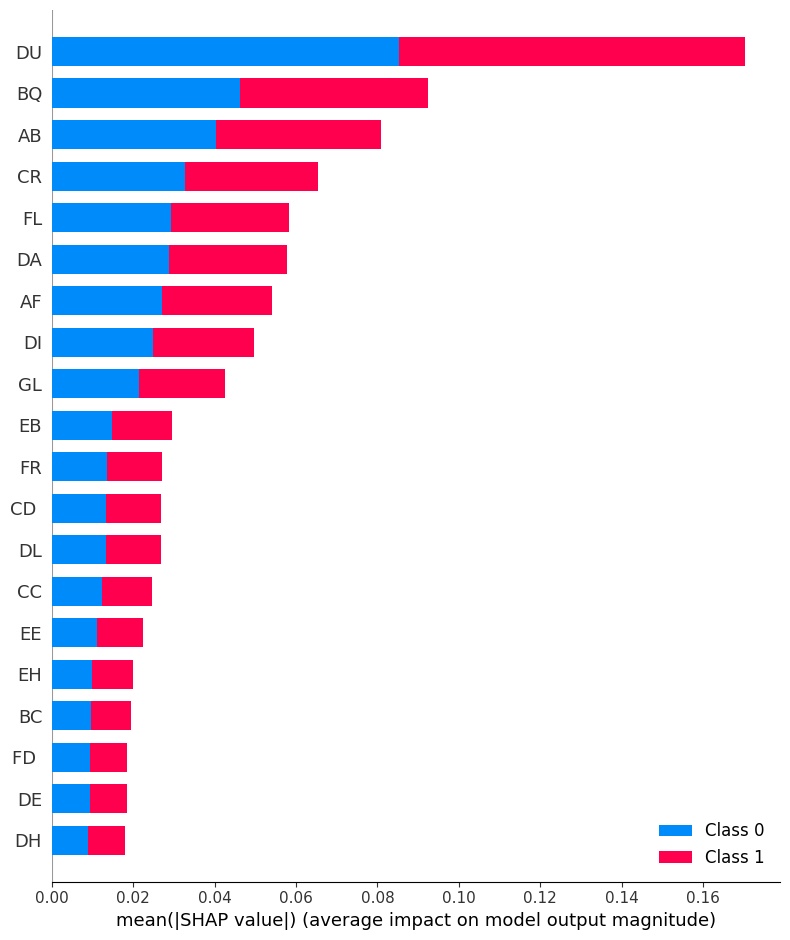

In [168]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
# print(shap_values)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)